In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.enable_eager_execution()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# GAN = Glash
codings_size = 250

generator = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, activation='relu', input_shape=[codings_size]),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(codings_size, activation='sigmoid')
])

discriminator = tf.keras.models.Sequential([
    tf.keras.layers.Dense(150, activation='relu', input_shape=[codings_size]),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

glash = tf.keras.models.Sequential([generator, discriminator])

2021-11-02 00:17:04.237985: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-02 00:17:04.238166: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-02 00:17:04.239142: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
discriminator.compile(loss='binary_crossentropy', optimizer='Adam')
discriminator.trainable = False
glash.compile(loss='binary_crossentropy', optimizer='Adam')

In [5]:
dataset = np.array(np.split(np.array([np.random.normal(10, 0.1, 250) for i in range(50)]), 5))
print(dataset.shape)
batch_size = 10

(5, 10, 250)


In [6]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=100):
    generator, discriminator = glash.layers
    for epoch in range(n_epochs):
        for X_batch in dataset:
            # training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]]*batch_size+[[1.]]*batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            
            # Phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]]*batch_size)
            discriminator.trainable = False
            glash.train_on_batch(noise, y2)
            
train_gan(glash, dataset, batch_size, codings_size)

2021-11-02 00:17:04.741120: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-02 00:17:04.764618: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


In [12]:
new = np.array([np.random.normal(1, 0.2, codings_size)])
test = generator.predict(new)

(array([21., 18., 23., 26., 21., 18., 32., 23., 41., 27.]),
 array([0.08220235, 0.1698152 , 0.25742805, 0.3450409 , 0.43265373,
        0.5202666 , 0.6078794 , 0.69549227, 0.78310513, 0.87071794,
        0.9583308 ], dtype=float32),
 <BarContainer object of 10 artists>)

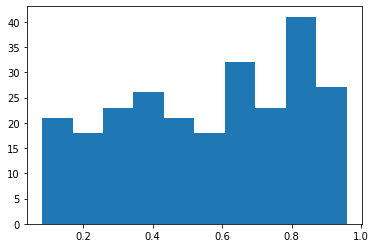

In [17]:
plt.hist(test[0])

(array([10., 13., 23., 59., 52., 45., 29., 12.,  6.,  1.]),
 array([0.5244324 , 0.63100464, 0.73757687, 0.84414911, 0.95072135,
        1.05729358, 1.16386582, 1.27043806, 1.37701029, 1.48358253,
        1.59015477]),
 <BarContainer object of 10 artists>)

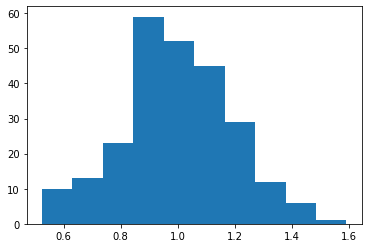

In [16]:
plt.hist(new[0])

In [17]:
class Glash:

    def __init__(self, no_samples, input_shape):
        self.no_samples = no_samples
        # GAN Architecture
        # Generator part
        generator = tf.keras.models.Sequential([
            tf.keras.layers.Dense(50, activation='relu', input_shape=input_shape),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.Dense(self.no_samples, activation='sigmoid')
        ])

        # Discriminator side
        discriminator = tf.keras.models.Sequential([
            tf.keras.layers.Dense(150, activation='relu', input_shape=[self.no_samples]),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        glash = tf.keras.models.Sequential([generator, discriminator])
        self.glash = glash
        self.generator = generator
        self.discriminator = discriminator

    def glash_compile(self):
        self.discriminator.compile(loss='binary_crossentropy', optimizer='Adam')
        self.discriminator.trainable = False
        self.glash.compile(loss='binary_crossentropy', optimizer='Adam')
        
    def data_processing(self, dataset, batch_size):
        if type(dataset) == list:
            dataset = np.array(dataset)
        
        if type(dataset) == np.ndarray:
            proc_dataset = np.array(np.split(dataset, int(len(dataset)/batch_size)))
        
        else:
            return "Input dataset has the wrong format"
        
        return proc_dataset

    def train_glash(self, dataset, batch_size, no_epochs=100):
        generator, discriminator = self.glash.layers
        for epoch in range(no_epochs):
            for X_batch in dataset:
                # Phase 1- Training the discriminator
                noise = tf.random.normal(shape=[batch_size, self.no_samples])
                generated_dist = generator(noise)
                X_fake_and_real = tf.concat([generated_dist, X_batch], axis=0)
                y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
                discriminator.trainable = True
                discriminator.train_on_batch(X_fake_and_real, y1)

                # Phase 2 - Training the generator
                noise = tf.random.normal(shape=[batch_size, self.no_samples])
                y2 = tf.constant([[1.]] * batch_size)
                discriminator.trainable = False
                self.glash.train_on_batch(noise, y2)

    def glash_predict(self, sample):
        return self.generator(sample)

In [20]:
test_obj = Glash(250, [250])
test_obj.glash_compile()

#dataset = np.array(np.split(np.array([np.random.normal(10, 0.1, 250) for i in range(50)]), 5))
batch_size = 10
dataset = [np.random.normal(10, 0.1, 250) for i in range(50)]
dataset = test_obj.data_processing(dataset, batch_size)

test_obj.train_glash(dataset, batch_size)
new = np.array([np.random.normal(1, 0.2, 250)])
test = test_obj.glash_predict(new)

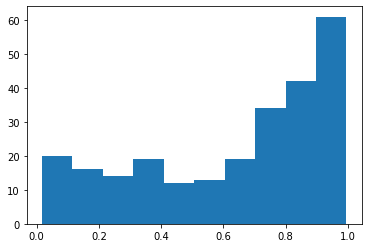

In [21]:
plt.hist(test)
plt.show()